In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from geopy.distance import geodesic
import shapely.speedups
from tqdm import tqdm
from quetzal.model import stepmodel
from quetzal.engine import engine
from quetzal.io import excel

# Preparation of the transport network.
## Saves aggregated bus and short-distance rail network with other PT modes.
## Needs PT networks.

In [3]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Loading StepModel with PT networks...
sm = stepmodel.read_json(input_path + 'de_pt_network')
bus = stepmodel.read_json(input_path + 'de_pt_network_bus')

In [7]:
sm.nodes.sample()

,route_type,stop_name,geometry
index,,,
rs_n_14792,None,Wernshausen,POINT (10.35361 50.72124)


## Check and correct network integrity

In [12]:
# FIRST: Set time of free-rider links
# Default velocity of 14 m/s for rail links
sm.links.loc[sm.links['time']==0, 'time'] = sm.links.loc[
    sm.links['time']==0, 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m)) / 14
# 8 m/s for bus links
bus.links.loc[bus.links['time']==0, 'time'] = bus.links.loc[
    bus.links['time']==0, 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m)) / 8

In [13]:
# For replacing missing nodes
def find_geo(node):
    if node in sm.links['a']:
        return geometry.Point(sm.links.loc[sm.links['a']==node, 'geometry'][0].coords[0])
    else:
        return geometry.Point(sm.links.loc[sm.links['b']==node, 'geometry'][0].coords[-1])
type_dict = {('coach', 'n'): 'coach', ('c', 'n'): 'coach', ('bus', 'n'): 'bus', ('bus', 'x'): 'bus',
             ('subway', 'n'): 'bus', ('ferry', 'n'): 'bus', ('tram', 'n'): 'bus',
             ('rail', 'short'): 'rail_short', ('rs', 'n'): 'rail_short',
             ('rail', 'long'): 'rail_long', ('rl', 'n'): 'rail_long'}

In [14]:
# Check nodeset integrity for later steps to work
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    if manual:
        print('Found {} orphan nodes'.format(len(sm.orphan_nodes)))
        print('Found {} missing nodes'.format(len(sm.missing_nodes)))
    sm.nodes.drop(sm.orphan_nodes, inplace=True)
    sm.nodes = sm.nodes.append(pd.DataFrame(index=sm.missing_nodes,
        data={'route_type': [type_dict[tuple(n.split('_')[:2])] for n in sm.missing_nodes],
              'stop_name': [np.nan]*len(sm.missing_nodes),
              'geometry': [find_geo(n) for n in sm.missing_nodes]}))
    # Test integrity again
    sm.integrity_test_nodeset_consistency()

Found 5 orphan nodes
Found 0 missing nodes
no road_links or road_nodes


In [8]:
# Check bus nodeset integrity for later steps to work
try:
    bus.integrity_test_nodeset_consistency()
except AssertionError:
    if manual:
        print('Found {} orphan nodes'.format(len(bus.orphan_nodes)))
        print('Found {} missing nodes'.format(len(bus.missing_nodes)))
    bus.nodes.drop(bus.orphan_nodes, inplace=True)
    bus.nodes = bus.nodes.append(pd.DataFrame(index=bus.missing_nodes,
        data={'route_type': [type_dict[tuple(n.split('_')[:2])] for n in bus.missing_nodes],
              'stop_name': [np.nan]*len(bus.missing_nodes),
              'geometry': [find_geo(n) for n in bus.missing_nodes]}))
    # Test integrity again
    bus.integrity_test_nodeset_consistency()

no road_links or road_nodes


In [15]:
# Test sequences
# Use an own function because quetzal's takes ages
def test_sequences(trip):
    assert len(trip)==trip['link_sequence'].max(), \
        'broken sequence in trip {}'.format(trip['trip_id'].unique()[0])

In [16]:
# Fix sequences
# Use an own function because quetzal's takes ages
def fix_sequences(trip):
    trip = trip.sort_values('link_sequence')
    # Check link succession
    ind = list(trip.index)
    for i in range(len(trip.index) - 1):
        try:
            assert trip.loc[ind[i], 'b'] == trip.loc[ind[i+1], 'a'], \
                'broken trip {}: stop {} has no successor link'.format(
                    trip['trip_id'].unique()[0], trip.loc[ind[i], 'b'])
        except AssertionError:
            trip.loc[ind[i+1]:ind[-1], 'trip_id'] = \
                trip.loc[ind[i+1]:ind[-1], 'trip_id'] + '_' + str(i)
    # Repair sequences
    if len(trip) != trip['link_sequence'].max():
        trip['link_sequence'] = trip.groupby('trip_id')['link_sequence'].apply(
            lambda t: [j for j in range(1, len(t.index)+1)]).sum()
    return trip

In [17]:
# Test and save broken sequences
def test_sequences_save(trip):
    if len(trip)!=trip['link_sequence'].max():
        return list(trip.index)

In [18]:
tqdm.pandas()
try:
    sm.links.groupby('trip_id').progress_apply(test_sequences)
except AssertionError:
    links = sm.links.groupby('trip_id').progress_apply(fix_sequences).reset_index(level=0, drop=True)
    links.groupby('trip_id').progress_apply(test_sequences)
    sm.links = links

100%|████████████████████████████████████████████████████████████████████████████| 8867/8867 [00:02<00:00, 3477.40it/s]


In [13]:
try:
    bus.links.groupby('trip_id').progress_apply(test_sequences)
except AssertionError:
    broken_seqs = bus.links.groupby('trip_id').progress_apply(test_sequences_save)
    links = bus.links.loc[broken_seqs.loc[broken_seqs.notna()].sum()
                         ].groupby('trip_id').progress_apply(fix_sequences)
    links.reset_index(level=0, drop=True, inplace=True)
    links.groupby('trip_id').progress_apply(test_sequences)
    bus.links = bus.links.drop(broken_seqs.loc[broken_seqs.notna()].sum()).append(links)

100%|████████████████████████████████████████████████████████████████████████| 212259/212259 [01:09<00:00, 3036.35it/s]


In [14]:
assert len(bus.nodes['route_type'].unique()) == 1

In [15]:
# Divide nodes
if manual: print(sm.nodes.shape)
disagg_nodes = sm.nodes.loc[sm.nodes['route_type']=='rail_short'].append(bus.nodes)
sm.nodes = sm.nodes.loc[sm.nodes['route_type']!='rail_short']
#disagg_nodes = bus.nodes
if manual: print(disagg_nodes.shape)

(15394, 3)
(427815, 3)


In [16]:
# Divide links
if manual: print(sm.links.shape)
disagg_links = sm.links.loc[sm.links['route_type']=='rail_short'].append(bus.links)
sm.links = sm.links.loc[sm.links['route_type']!='rail_short']
#disagg_links = bus.links
if manual: print(disagg_links.shape)

(213130, 8)
(3392365, 8)


In [17]:
# Number of trips
len(disagg_links['trip_id'].unique())

227239

In [18]:
# Map nodes to zones
sm.nodes = gpd.GeoDataFrame(sm.nodes, crs=sm.epsg)
disagg_nodes = gpd.GeoDataFrame(disagg_nodes, crs=sm.epsg)
shapely.speedups.enable()
sm.nodes['FID'] = np.nan
disagg_nodes['FID'] = np.nan
for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
    sm.nodes.loc[sm.nodes['geometry'].within(zone['geometry'].buffer(1e-3)), 'FID'] = zone['NUTS_ID']
    disagg_nodes.loc[disagg_nodes['geometry'].within(zone['geometry'].buffer(1e-3)), 'FID'] = zone['NUTS_ID']
# Drop zones outside the model zones
sm.nodes = sm.nodes[sm.nodes['FID'].notna()]
disagg_nodes = disagg_nodes[disagg_nodes['FID'].notna()]

100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [16:24<00:00,  2.46s/it]


In [19]:
# long-distance stop clusters that overlay each other
len(sm.nodes.loc[sm.nodes['geometry'].duplicated(keep=False)])#.groupby('stop_name')

906

## Find relevant trips

Mark trips that are relevant for inter-zonal connectivity and drop the rest.

In [21]:
# Find trips that are only within one zone
node_dict = disagg_nodes['FID'].to_dict()
disagg_links['a_zone'] = disagg_links['a'].map(node_dict)
disagg_links['b_zone'] = disagg_links['b'].map(node_dict)
relevant = disagg_links.groupby('trip_id').apply(
    lambda t: (t['a_zone']!=t['b_zone']).any()).to_dict()
disagg_links.drop(['a_zone', 'b_zone'], inplace=True, axis=1)

In [22]:
agg_links = disagg_links.loc[disagg_links['trip_id'].map(relevant)]
len(agg_links)

1020051

In [23]:
# Build footpaths from long-distance links to short-distance
sm.footpaths = sm.footpaths.iloc[0:0]
for o in sm.nodes['route_type'].unique():
    for d in disagg_nodes['route_type'].unique():
        if o != d:
            ntlegs = engine.ntlegs_from_centroids_and_nodes(
                sm.nodes.loc[sm.nodes['route_type']==o],
                disagg_nodes.loc[disagg_nodes['route_type']==d],
                short_leg_speed=params['pt_access']['speed_walk'],
                long_leg_speed=params['pt_access']['speed_bicycle'],
                threshold=params['pt_access']['catchment_radius_walk'],
                n_neighbors=params['access-egress_links']['n_long-pt_short-pt'],
                coordinates_unit=sm.coordinates_unit)
            if o == 'air':
                ntlegs = ntlegs.loc[ntlegs['distance']<=
                                    params['access-egress_links']['walk_air_max_dist']]
            else:
                ntlegs = ntlegs.loc[ntlegs['distance']<=
                                    params['access-egress_links']['walk_max_dist']]
            sm.footpaths = sm.footpaths.append(ntlegs)
len(sm.footpaths)

5132

In [24]:
# Find trips that connect long-distance stops
trip_dict = disagg_links.groupby('a').agg({'trip_id': list}).to_dict()['trip_id']
trip_dict.update(disagg_links.loc[~disagg_links['b'].isin(trip_dict.keys())
                                 ].groupby('b').agg(list)['trip_id'].to_dict())
trip_set = set(sm.footpaths.loc[sm.footpaths['b'].isin(trip_dict.keys()),
                                'b'].map(trip_dict).sum())
# Drop trips that are already found above
trip_set = trip_set.difference(set(agg_links['trip_id']))
len(trip_set)

7119

In [25]:
# Add these trips to agg_links
agg_links = agg_links.append(disagg_links.loc[disagg_links['trip_id'].isin(trip_set)])
len(agg_links)

1147653

In [26]:
# Drop unused nodes
agg_nodes = disagg_nodes.loc[agg_links[['a', 'b']].stack().unique()]
agg_nodes.shape

(206078, 4)

## Build footpaths

In addition to those generated above, build footpaths between agg_nodes, between long-distance nodes (because they overlay each other), and between centroids.

In [27]:
# Build footbaths between aggregated short-distance nodes
for o in agg_nodes['route_type'].unique():
    for d in agg_nodes['route_type'].unique():
        if o != d:
            ntlegs = engine.ntlegs_from_centroids_and_nodes(
                agg_nodes.loc[agg_nodes['route_type']==o],
                agg_nodes.loc[agg_nodes['route_type']==d],
                short_leg_speed=params['pt_access']['speed_walk'],
                long_leg_speed=params['pt_access']['speed_bicycle'],
                threshold=params['pt_access']['catchment_radius_walk'],
                n_neighbors=params['access-egress_links']['n_short-pt_short-pt'],
                coordinates_unit=sm.coordinates_unit)
            ntlegs = ntlegs.loc[ntlegs['distance']<=
                                params['access-egress_links']['walk_max_dist']]
            sm.footpaths = sm.footpaths.append(ntlegs)
len(sm.footpaths)

62938

In [30]:
# Between long-distance nodes
ntlegs = engine.ntlegs_from_centroids_and_nodes(
    sm.nodes,
    sm.nodes,
    short_leg_speed=params['pt_access']['speed_walk'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=params['access-egress_links']['n_long-pt_long-pt'],
    coordinates_unit=sm.coordinates_unit)
ntlegs = ntlegs.loc[ntlegs['distance']<=
                    params['access-egress_links']['walk_max_dist']]
ntlegs.drop_duplicates(['a', 'b'], inplace=True)
sm.footpaths = sm.footpaths.append(ntlegs)
len(sm.footpaths)

73784

In [31]:
# Generate footpaths between centroids
'''ntlegs = engine.ntlegs_from_centroids_and_nodes(
    sm.centroids,
    sm.centroids,
    short_leg_speed=params['pt_access']['speed_bicycle'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=params['access-egress_links']['n_bicycle_between_zones'],
    coordinates_unit=sm.coordinates_unit)
ntlegs = ntlegs.loc[ntlegs['distance']<=
                    params['access-egress_links']['bicycle_max_dist']]
ntlegs = ntlegs.loc[ntlegs['distance']!=0]
ntlegs.drop_duplicates(['direction', 'distance', 'time'], inplace=True)
sm.footpaths = sm.footpaths.append(ntlegs)'''
len(sm.footpaths)

73784

In [32]:
# Reindex
sm.footpaths.drop_duplicates(['a', 'b'], inplace=True)
sm.footpaths.reset_index(drop=True, inplace=True)
sm.footpaths.index = 'foot_' + pd.Series(sm.footpaths.index).astype(str)
sm.footpaths.sample()

,a,b,direction,distance,geometry,long_leg_speed,rank,short_leg_speed,speed,speed_factor,time
foot_37168,bus_n_216169,rail_short_n_14724,access,486.529978,"LINESTRING (12.38467 52.94637, 12.39056 52.94892)",17.0,0.0,5.0,5.0,0.986438,350.301584


In [33]:
# Drop unneccessary columns
cols = ['speed_factor', 'short_leg_speed', 'long_leg_speed', 'rank']
sm.footpaths.drop(cols, axis=1, inplace=True, errors='ignore')

## Connect to centroids

Build access/egress links to the most important stops.

In [34]:
# Compute controids
sm.centroids = sm.zones.copy()
sm.centroids['geometry'] = sm.centroids['geometry'].apply(lambda g: g.centroid)

In [35]:
# Count the connectivity of start nodes in links table
n_links_dict = sm.links[['a', 'b']].append(agg_links[['a', 'b']]).stack().value_counts().to_dict()
agg_links['n_links'] = agg_links['a'].map(n_links_dict)

In [36]:
# Choose which nodes to connect
def get_first_node(g): # Some nodes might not be in disagg_nodes
    n = 0
    while n < len(g):
        if g['a'][n] in node_dict.keys():
            break
        else:
            n += 1
    return g['a'][n] if n < len(g) else g['b'][n-1]
# Take one node per trip_id with the highest connectivity
# Take only nodes with higher connectivity for short-distances
nodes_short = agg_links.loc[agg_links['n_links']>2].sort_values(
    'n_links').groupby('trip_id').apply(get_first_node)#.first()['a']

In [37]:
# Every node must exist in the nodes table
assert len(set(nodes_short).difference(set(disagg_nodes.index))) == 0

In [38]:
# Compute PT access and egress links for short-distance trips
node_dict = disagg_nodes['FID'].to_dict()
nodes_short = list(set(nodes_short))
access = gpd.GeoDataFrame(
    data={'a': [node_dict[n] for n in nodes_short], # centroid FID
          'b': nodes_short,
          'route_type': [type_dict[tuple(n.split('_')[:2])] for n in nodes_short],
          'direction': ['access']*len(nodes_short)},
    geometry=[geometry.LineString([sm.centroids.loc[node_dict[n], 'geometry'].coords[0],
                                   disagg_nodes.loc[n, 'geometry'].coords[0]])
              for n in nodes_short],
    crs=sm.epsg)
egress = gpd.GeoDataFrame( # turn it around
    data={'a': list(access['b']),
          'b': list(access['a']),
          'route_type': [type_dict[tuple(n.split('_')[:2])] for n in nodes_short],
          'direction': ['eggress']*len(nodes_short)}, # name in quetzal
    geometry=[geometry.LineString([l.coords[-1], l.coords[0]]) for l in list(access['geometry'])],
    crs=sm.epsg)
sm.zone_to_transit = access.append(egress).reset_index(drop=True)
len(sm.zone_to_transit)

70266

In [39]:
# Compute PT access and egress links for long-distance trips
zone_dict = sm.nodes['FID'].to_dict()
for t in sm.links['route_type'].unique():
    ntlegs = engine.ntlegs_from_centroids_and_nodes(
        sm.centroids,
        sm.nodes.loc[sm.nodes['route_type']==t],
        short_leg_speed=params['pt_access']['speed_walk'],
        long_leg_speed=params['pt_access']['speed_car'], # Take the car for longer trips
        threshold=params['pt_access']['catchment_radius_walk'],
        n_neighbors=min(len(sm.nodes.loc[sm.nodes['route_type']==t]),
                        sm.nodes.groupby(['route_type', 'FID']).count()['stop_name'].max()),
        coordinates_unit=sm.coordinates_unit)
    # Cut off long links
    ntlegs = ntlegs.loc[ntlegs['distance']<=
                        params['access-egress_links']['pt_max_dist']]
    # Drop links to other zones
    ntlegs = ntlegs.loc[(ntlegs['a']==ntlegs['b'].map(zone_dict)) |
                        (ntlegs['b']==ntlegs['a'].map(zone_dict))]
    ntlegs['route_type'] = t
    # Merge
    sm.zone_to_transit = sm.zone_to_transit.append(ntlegs)
sm.zone_to_transit.reset_index(drop=True, inplace=True)
len(sm.zone_to_transit.index)

72970

In [40]:
# Prepare links for filtering
sm.zone_to_transit['distance'] = sm.zone_to_transit['geometry'].apply(lambda l: l.length)
access = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access']
access['n_links'] = access['b'].map(n_links_dict)
egress = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='eggress']
egress['n_links'] = egress['a'].map(n_links_dict)

In [41]:
# Filter: search for highest connectivity and shortest links per route_type
access = access.sort_values('n_links', ascending=False).groupby(['a', 'route_type']).nth(
    list(range(params['access-egress_links']['keep_n_highest_connectivity']))
).reset_index().append(
        access.sort_values('distance').groupby(['a', 'route_type']).nth(
            list(range(params['access-egress_links']['keep_n_closest']))
).reset_index()).drop_duplicates(['a', 'b'])
egress = egress.sort_values('n_links', ascending=False).groupby(['b', 'route_type']).nth(
    list(range(params['access-egress_links']['keep_n_highest_connectivity']))
).reset_index().append(
        egress.sort_values('distance').groupby(['b', 'route_type']).nth(
            list(range(params['access-egress_links']['keep_n_closest']))
).reset_index()).drop_duplicates(['a', 'b'])

In [42]:
sm.zone_to_transit = access.append(egress).reset_index(drop=True)
sm.zone_to_transit.drop('n_links', axis=1, inplace=True)
sm.zone_to_transit.shape

(9096, 12)

### Parametrise access and egress  links

Add distance, speed and time. Average distances by zone and mode should have been calculated based on census data before.

In [46]:
# Drop unneccessary columns
cols = ['speed_factor', 'short_leg_speed', 'long_leg_speed', 'rank']
sm.zone_to_transit.drop(cols, axis=1, inplace=True, errors='ignore')

In [60]:
# Load distances to PT stops from census data
clusters = pd.read_csv('../input/spatial_census_refined.csv')
#clusters.set_index('Unnamed: 0', inplace=True)
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
#pop_col = 'population'
node_col = 'node_id'
# Create a zone - distance - type dict
# Take the mean weighted distance
zone = 'FID' if 'FID' in clusters.columns else 'NUTS_ID'
zone_type_dist = clusters.groupby([zone, 'route_type']).agg(
    {mean_dist_col: 'mean'}).to_dict()[mean_dist_col]

In [61]:
# Adjust distances
access = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access']
egress = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='eggress']
access['distance'] = [zone_type_dist[(z, t)] if (z, t) in zone_type_dist.keys() else np.nan
                      for z,t in zip(access['a'], access['route_type'])]
egress['distance'] = [zone_type_dist[(z, t)] if (z, t) in zone_type_dist.keys() else np.nan
                      for z,t in zip(egress['b'], egress['route_type'])]
sm.zone_to_transit = access.append(egress)

<AxesSubplot:>

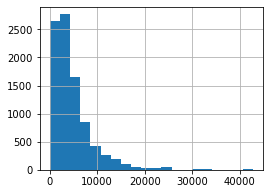

In [66]:
# Distance distribution among access/egress links
sm.zone_to_transit['distance'].hist(bins=20, figsize=(4,3))

In [62]:
len(sm.zone_to_transit.loc[sm.zone_to_transit['distance'].isna()])

2

In [63]:
# Connectors to/from nodes in other zones
# Drop NaN, because they cause that people don't take short-distance PT,
# but walk over to the next airport and walk to the neighboring centroid
sm.zone_to_transit = sm.zone_to_transit.loc[sm.zone_to_transit['distance'].notna()]
sm.zone_to_transit.shape

(9094, 8)

In [64]:
# Correct speeds based on access/egress modes
speeds = {'walk': params['pt_access']['speed_walk'],
          'bicycle': params['pt_access']['speed_bicycle'],
          'car': params['pt_access']['speed_car']} # km/h
urban_dict = sm.centroids['urbanisation'].to_dict()
access = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access']
egress = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='eggress']
access['speed'] = [sum([speed * params['pt_access']['urban'+str(u)+'_'+mode+'_share'
                                                   ] for mode, speed in speeds.items()])
                   for u in list(access['a'].map(urban_dict))]
egress['speed'] = [sum([speed * params['pt_access']['urban'+str(u)+'_'+mode+'_share'
                                                   ] for mode, speed in speeds.items()])
                   for u in list(egress['b'].map(urban_dict))]
sm.zone_to_transit = access.append(egress)

<AxesSubplot:>

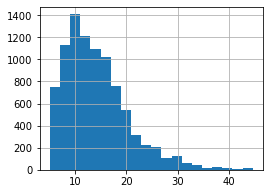

In [65]:
# Speed distribution among access/egress links
sm.zone_to_transit['speed'].hist(bins=20, figsize=(4,3))

In [67]:
# Alter time of PT legs
sm.zone_to_transit['time'] = sm.zone_to_transit['distance'] / \
    sm.zone_to_transit['speed'] * 3.6 # in s

In [68]:
# Ditch all legs which take too long
sm.zone_to_transit = sm.zone_to_transit.loc[sm.zone_to_transit['time']<2*3600]
len(sm.zone_to_transit)

9080

In [69]:
# Every zone should have an access and an egress link to PT
try:
    assert sm.zones['NUTS_ID'].isin(list(sm.zone_to_transit['a'])).all()
except AssertionError:
    if manual: print(sm.zones.loc[~sm.zones['NUTS_ID'].isin(list(sm.zone_to_transit['a']))].index)
try:
    assert sm.zones['NUTS_ID'].isin(list(sm.zone_to_transit['b'])).all()
except AssertionError:
    if manual: print(sm.zones.loc[~sm.zones['NUTS_ID'].isin(list(sm.zone_to_transit['b']))].index)

<AxesSubplot:>

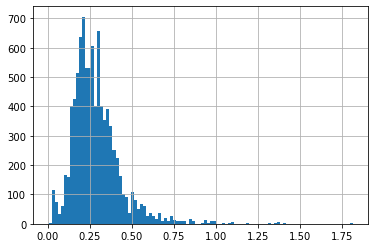

In [70]:
# Time distribution of access/egress links
(sm.zone_to_transit['time']/3600).hist(bins=100)

In [71]:
sm.zone_to_transit.sample()

,a,b,direction,distance,geometry,route_type,speed,time
6039,rail_short_n_9308,DE736,eggress,6985.929097,"LINESTRING (8.87323 51.27871, 8.88897 51.19062)",rail_short_distance,18.689474,1345.64216


## Remove unneccessary stops
Bus and short-distance rail service in the GTFS feeds contain trips with not further connected intermediate stops. Thus, the PT network graph can be reduced without loss of information.

In [72]:
# Count connectivity
n_links_dict = agg_links[['a', 'b']].stack().value_counts().to_dict()
n_connectors_dict = sm.zone_to_transit[['a', 'b']].append(
    sm.footpaths[['a', 'b']]).stack().value_counts().to_dict()
agg_nodes['n_links'] = agg_nodes.index.map(n_links_dict)
agg_nodes['n_connectors'] = agg_nodes.index.map(n_connectors_dict).fillna(0)

In [73]:
# Keep interconnected rail trips but drop all bus trips
# without connection to another mode or centroid
agg_nodes = agg_nodes.loc[
    ((agg_nodes['route_type']!='bus') &
     ((agg_nodes['n_links'] > 2) |
      (agg_nodes['n_connectors'] > 0))
    ) | (
     (agg_nodes['route_type']=='bus') &
      ((agg_nodes['n_connectors'] > 0) |
       (agg_nodes.index.isin(nodes_short)))
    )]

In [74]:
if manual:
    print(agg_nodes.loc[agg_nodes['route_type']=='bus'].shape)
    print(agg_nodes.loc[agg_nodes['route_type']!='bus'].shape)

(46524, 6)
(13221, 6)


### Aggregate links

Aggregate those those trips with removed nodes.

In [75]:
# Function for aggregating links
geo_dict = agg_nodes['geometry'].to_dict()
def agg_trips(trip):
    # Drop links with missing nodes
    missing_nodes = list(set(trip[['a', 'b']].stack()).difference(set(agg_nodes.index)))
    trip_agg = trip.loc[~((trip['a'].isin(missing_nodes)) & trip['b'].isin(missing_nodes))
                       ].sort_values('link_sequence')
    if len(trip_agg.index) == 0:
        # Trip is fully irrelevant
        return
    
    if len(missing_nodes)==0 and len(trip.index)==len(trip_agg.index):
        # This trip is not affected
        return trip
    
    # Repair link succession
    ind = list(trip_agg.index)
    for i in range(len(ind) - 1):
        if trip_agg.loc[ind[i], 'b'] in missing_nodes:
            trip_agg.loc[ind[i + 1], 'a'] = trip_agg.loc[ind[i], 'a']
            trip_agg.drop(ind[i], inplace=True)
            i = i + 1
    
    ind = list(trip_agg.index)
    if len(trip_agg.index) > 0 and trip_agg.loc[ind[0], 'a'] in missing_nodes:
        # Drop unused first link
        trip_agg = trip_agg.iloc[1:]
    if len(trip_agg.index) > 0 and trip_agg.loc[ind[-1], 'b'] in missing_nodes:
        # Drop unused last link
        trip_agg = trip_agg.iloc[:-1]
    ind = list(trip_agg.index)
    if len(ind) == 0:
        return
    
    # Aggregate travel time
    for i in range(len(ind) - 1):
        try:
            assert trip_agg.loc[ind[i], 'b'] == trip_agg.loc[ind[i+1], 'a'], \
                'broken sequence in trip {}: stop {} has no successor link'.format(
                    trip_agg['trip_id'].unique()[0], trip_agg.loc[ind[i], 'b'])
        except AssertionError:
            # Drop this trip
            return
        if trip_agg.loc[ind[i + 1], 'link_sequence'] - trip_agg.loc[ind[i], 'link_sequence'] > 1:
            trip_agg.loc[ind[i], 'time'] = trip.loc[ind[i]:ind[i+1], 'time'].sum() - \
                trip_agg.loc[ind[i+1], 'time'] # pandas slicing includes both boundaries
    
    # Reindex the sequence numbers
    trip_agg['link_sequence'] = [i for i in range(1, len(trip_agg.index)+1)]
    
    # Build geometries
    try:
        trip_agg['geometry'] = [geometry.LineString([geo_dict[a], geo_dict[b]])
                                for a,b in zip(trip_agg['a'], trip_agg['b'])]
    except KeyError:
        return
    
    return trip_agg

In [76]:
# Faster variant for using multiple cores
#import multiprocessing as mp
#with mp.Pool(processes=10) as p:
#    agg_links = pd.concat(p.map(
#        agg_trips, [g for _, g in disagg_links.groupby('trip_id')]))
agg_links = agg_links.groupby('trip_id').progress_apply(
    agg_trips).reset_index(level=0, drop=True)

"import multiprocessing as mp\nwith mp.Pool(processes=10) as p:\n    agg_links = pd.concat(p.map(\n        agg_trips, [g for _, g in disagg_links.groupby('trip_id')]))"

In [78]:
# Links with stops that should be dropped
errors = agg_links.loc[~(agg_links['a'].isin(list(agg_nodes.index))) |
    ~(agg_links['b'].isin(list(agg_nodes.index)))]
if manual:
    print(len(errors))
    print(errors['link_sequence'].unique())
    print(errors['route_type'].unique())

0
[]
[]


In [79]:
# Drop these erronous trips
agg_links = agg_links.loc[~agg_links['trip_id'].isin(list(agg_links.loc[errors.index, 'trip_id']))]
agg_links.shape

(372462, 9)

In [80]:
# Drop trips with different IDs but same stop sequences
s = agg_links.groupby('trip_id').agg(tuple).drop_duplicates('a', keep='first')
agg_links = agg_links.loc[agg_links['trip_id'].isin(s.index)]
agg_links.shape

(319427, 9)

## Merge aggregated links and nodes with the model

In [81]:
# Re-add links to model
sm.links = sm.links.append(agg_links)
sm.links.shape

(351366, 9)

In [82]:
# Re-add nodes to the model
sm.nodes = sm.nodes.append(agg_nodes)
sm.nodes.shape

(61111, 6)

In [83]:
try:
    sm.integrity_test_nodeset_consistency()
except AssertionError:
    if manual:
        print('Number of orphan nodes: {}'.format(
            len(sm.orphan_nodes)))
        print('Number of missing nodes: {}'.format(
            len(sm.missing_nodes)))

Number of orphan nodes: 400
Number of missing nodes: 0


In [84]:
assert len(sm.missing_nodes) == 0
if len(sm.orphan_nodes) > 0:
    sm.nodes = sm.nodes.drop(sm.orphan_nodes)
    sm.nodes.shape

In [85]:
sm.nodes.drop(['n_links', 'n_connectors'], axis=1, inplace=True, errors='ignore')
sm.links.drop(['n_links', 'n_connectors'], axis=1, inplace=True, errors='ignore')

In [86]:
sm.links.groupby('trip_id').progress_apply(test_sequences)

100%|██████████████████████████████████████████████████████████████████████████| 54080/54080 [00:06<00:00, 8193.02it/s]


""


In [87]:
# Add bus service to ancilliary
sm.pt_routes = sm.pt_routes.append(bus.pt_routes.loc[
    bus.pt_routes['route_id'].isin(sm.links['route_id'].unique())])
sm.agencies = sm.agencies.append(bus.agencies.loc[
    bus.agencies['agency_id'].isin(sm.pt_routes['agency_id'].unique())])

In [88]:
# Now, we have bus services in the same tables
sm.pt_route_types.append('bus')

## Save model
And reduce the file size

In [89]:
# Reduce file size by shortening node index names
"""sm.nodes['index'] = [i.replace('rail_short_n', 'r_s_n') for i in sm.nodes.index]
sm.nodes.set_index('index', drop=True, inplace=True)
sm.links['a'] = sm.links['a'].apply(lambda n: n.replace('rail_short_n', 'r_s_n'))
sm.links['b'] = sm.links['b'].apply(lambda n: n.replace('rail_short_n', 'r_s_n'))
sm.nodes['index'] = [i.replace('rail_long_n', 'r_l_n') for i in sm.nodes.index]
sm.nodes.set_index('index', drop=True, inplace=True)
sm.links['a'] = sm.links['a'].apply(lambda n: n.replace('rail_long_n', 'r_l_n'))
sm.links['b'] = sm.links['b'].apply(lambda n: n.replace('rail_long_n', 'r_l_n'))
# Shorten link index names
sm.links['index'] = [i.replace('rail_long', 'r_l').replace('rail_short', 'r_s')
                     for i in sm.links.index]
sm.links.set_index('index', drop=True, inplace=True)
# Shorten route type names
type_dict = {'rail_short_distance': 'rail_short', 'rail_long_distance': 'rail_long'}
sm.links['route_type'] = sm.links['route_type'].replace(type_dict)
sm.nodes['route_type'] = sm.nodes['route_type'].replace(type_dict)
sm.pt_route_types = [t.replace('_distance', '') for t in sm.pt_route_types]
"""
sm.links.loc[sm.links['route_type']=='rail_short'].sample()

In [94]:
# Cast columns to int
cols = ['time', 'link_sequence']
sm.links[cols] = sm.links[cols].astype(int)

In [95]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['a', 'b', 'link_sequence', 'route_id', 'time', 'trip_id']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [96]:
sm.links.shape

(351366, 2)

In [97]:
# Saving model...
sm.to_json(model_path + 'de_pt_network_agg',
           only_attributes=['zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')
sm.to_json(model_path + 'de_pt_network_ancillary',
           only_attributes=['agencies', 'pt_routes'],
           encoding='utf-8')

to_hdf(overwriting): 100%|████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 710.70it/s]


In [98]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')

In [99]:
# Rename access/egress links and footpaths
"""sm.zone_to_transit['route_type'].replace(type_dict, inplace=True)
sm.zone_to_transit['a'] = sm.zone_to_transit['a'].apply(lambda n: n.replace('rail_long_n', 'r_l_n'))
sm.zone_to_transit['a'] = sm.zone_to_transit['a'].apply(lambda n: n.replace('rail_short_n', 'r_s_n'))
sm.zone_to_transit['b'] = sm.zone_to_transit['b'].apply(lambda n: n.replace('rail_long_n', 'r_l_n'))
sm.zone_to_transit['b'] = sm.zone_to_transit['b'].apply(lambda n: n.replace('rail_short_n', 'r_s_n'))
sm.footpaths['a'] = sm.footpaths['a'].apply(lambda n: n.replace('rail_long_n', 'r_l_n'))
sm.footpaths['a'] = sm.footpaths['a'].apply(lambda n: n.replace('rail_short_n', 'r_s_n'))
sm.footpaths['b'] = sm.footpaths['b'].apply(lambda n: n.replace('rail_long_n', 'r_l_n'))
sm.footpaths['b'] = sm.footpaths['b'].apply(lambda n: n.replace('rail_short_n', 'r_s_n'))"""
sm.footpaths.sample()

In [100]:
# Save reduced access/egress links
sm.to_json(model_path + 'de_pt_access_egress', only_attributes=[
    'centroids', 'footpaths', 'zone_to_transit'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [00:10<00:00,  3.51it/s]
